# Data Storytelling: National Parks and their Biodiversity

This figure shows the 9 most endangered species in the US, including the Red Wolf and Franklin's Bumblebee. This Notebook investigates what features of a National Park we need to strengthen to provide the most efficient protection to our native species. <img src="https://t1.ea.ltmcdn.com/en/images/3/4/5/img_most_endangered_species_in_north_america_1543_600.jpg" width=300 heigth=300/>

Therefore the species composition and properties of 56 out of the 62 American National Parks are investigated. The central question that is investigated is:

#### <center> What drives the abundance of native species in a National Park?</center>

In [120]:
#load python packages
import os
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
df_norm = pd.read_csv('data/Normalized_perPark.csv',index_col=0)
df_park = pd.read_csv('data/Combo_Park_Bio.csv',index_col=0)
df_park = df_park.rename(columns={'Park Name.1':'Park Name'})
df_park['Cluster'] = df_norm['Clusters']
df_park['Present'] = df_park['Native_Present']+df_park['NotNative_Present']
df_park['Present_cat'] = pd.cut(df_park['Present'],bins=[0,500,1000,1500,2000,2500,5000],labels=['<500','<1000','<1500','<2000','<2500','>2500'])
df_bio= pd.read_csv('data/species.csv')
df_bio.drop('Unnamed: 13',axis=1,inplace=True)

/Users/lisahw/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning:

Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.



# Potential Questions

- To investigate this, these specific question are addressed:
- Is the size or location of the park relevant?
- Are there groups of animals that are more relevant than others?
- Can we identify subgroups of parks with common features? Do these features play a role for the abundance of native species?
- Is the population size (in respect to all species) a relevant indicator for the number of native species in a park?

## What information about species presence do we have?

In [61]:
df_bio.describe().transpose()

/Users/lisahw/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,count,unique,top,freq
Species ID,119248,119248,KOVA-1439,1
Park Name,119248,56,Great Smoky Mountains National Park,6623
Category,119248,14,Vascular Plant,65221
Order,117776,554,Poales,11453
Family,117736,2332,Asteraceae,8843
Scientific Name,119248,46022,Falco peregrinus,56
Common Names,119248,35826,None,27147
Record Status,119248,54,Approved,86254
Occurrence,99106,7,Present,83278
Nativeness,94203,5,Native,75950


### Where do we find endangered species?

In [190]:
parks_endangered = []
for var in ['Red Wolf','Staghorn Coral','Ridley Sea Turtle','California Condor']:
    print(var,':')
    for i in range(len(df_bio['Park Name'])):
        if var in df_bio['Common Names'].iloc[i]: 
            print('   ',df_bio['Park Name'].iloc[i])
            if df_bio['Park Name'].iloc[i] not in parks_endangered:
                j = np.where(df_park['Park Name']==df_bio['Park Name'].iloc[i])[0][0]
                parks_endangered.append(j)

Red Wolf :
    Great Smoky Mountains National Park
    Hot Springs National Park
Staghorn Coral :
    Biscayne National Park
    Dry Tortugas National Park
Ridley Sea Turtle :
    Biscayne National Park
    Redwood National Park
California Condor :
    Arches National Park
    Bryce Canyon National Park
    Canyonlands National Park
    Capitol Reef National Park
    Death Valley National Park
    Great Basin National Park
    Grand Canyon National Park
    Joshua Tree National Park
    Lassen Volcanic National Park
    Mesa Verde National Park
    Pinnacles National Park
    Sequoia and Kings Canyon National Parks
    Yosemite National Park
    Zion National Park


## Explore Dataset

In [118]:
df_park.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56 entries, Acadia National Park to Zion National Park
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   RecordStatus_Approved        56 non-null     int64  
 1   RecordStatus_InReview        56 non-null     int64  
 2   Occurrence_NotConfirmed      56 non-null     int64  
 3   Occurrence_NotPresent        56 non-null     int64  
 4   Occurrence_other             56 non-null     int64  
 5   Nativeness_other             56 non-null     int64  
 6   Abundance_ordinal            56 non-null     int64  
 7   Category_mobile              56 non-null     int64  
 8   Native_Present               56 non-null     int64  
 9   NotNative_Present            56 non-null     int64  
 10  Resident_Present             56 non-null     int64  
 11  Breeder_Present              56 non-null     int64  
 12  Vagrant_Present              56 non-null     int64

In [198]:
import plotly.express as px
import plotly.graph_objects as go
import math
# bla = np.sort(df_park['Present'])
# plt.plot(bla,'.')
# plt.show()
def bubbleplot(df_park,cat_01,cat_02,title,title_cat_01,title_cat_02,legend='Cluster',x_axis_type='linear',y_axis_type='linear',cross_plot=None):
    sizeref = 1/4*max(df_park['Native_Present'])/(100**2)
    hover_text = []
    bubble_size = []

    for index, row in df_park.iterrows():
        hover_text.append(('Park Name: {ParkName}<br>'+
                          'Size: {Acres}<br>'+
                          '# Species: {Present}<br>'+
                          '# Native Species: {Native_Present}<br>').format(ParkName=row['Park Name'],
                                                Acres=row['Acres'],
                                                Present=row['Present'],
                                                Native_Present=row['Native_Present']))
        bubble_size.append(math.sqrt(row['Native_Present']))
    df_park['text'] = hover_text
    df_park['size'] = bubble_size
    if legend == 'Cluster':
        present_bins = [str(cl) for cl in np.sort(df_park['Cluster'].unique())]  #['<500','<1000','<1500','<2000','<2500','>2500']
        present_data = {cat:df_park.query("Cluster == '%s'" %cat)
                                  for cat in present_bins} # Present_cat
        legend_title = 'Cluster'
    elif legend == 'Present_cat':
        present_bins = ['<500','<1000','<1500','<2000','<2500','>2500']
        present_data = {cat:df_park.query("Present_cat == '%s'" %cat)
                                  for cat in present_bins} # 
        legend_title = '# species (native & not-native)'

    # Create figure
    fig = go.Figure()

    for cat_name, cat in present_data.items():
        fig.add_trace(go.Scatter(
            x=cat[cat_01], y=cat[cat_02],
            name=cat_name, text=cat['text'],
            marker_size=cat['size'],
            ))

    fig.update_traces(mode='markers', marker=dict(sizemode='area',
                                                  sizeref=sizeref, line_width=2))
    if cross_plot:
        fig.add_trace(go.Scatter(x=df_park[cat_01][cross_plot],y=df_park[cat_02][cross_plot],name='Endangered',mode='markers',marker=dict(color='black')))
    fig.update_layout(
        title=title,
        xaxis=dict(
            title=title_cat_01,
            gridcolor='white',
            type=x_axis_type,
            gridwidth=2,
        ),
        yaxis=dict(
            title=title_cat_02,
            gridcolor='white',
            type=y_axis_type,
            gridwidth=2,
        ),
        legend=dict(title=legend_title)
    )
    fig.show()
    return fig;

In [199]:
cat_01 = 'Acres'
cat_02 = 'Abundance_ordinal'
title = 'Area vs. Abundance per Species'
title_cat_01 = 'Park Area (acres)'
title_cat_02 = 'Abundance per Species (oridnal)'
legend = 'Cluster'
fig = bubbleplot(df_park,cat_01,cat_02,title,title_cat_01,title_cat_02,x_axis_type='log',cross_plot=parks_endangered)
# ind = df_park['Park Name'] == 'Biscayne National Park'
# fig.add_trace(go.plot(x = df_park[cat_01][ind],y = df_park[cat_02][ind]),'kx')

In [202]:
cat_01 = 'Acres'
cat_02 = 'Latitude'
title = 'Area vs. Latitude'
title_cat_01 = 'Park Area (acres)'
title_cat_02 = 'Latitude'
fig =bubbleplot(df_park,cat_01,cat_02,title,title_cat_01,title_cat_02,x_axis_type='log',cross_plot=parks_endangered)


## Clustering

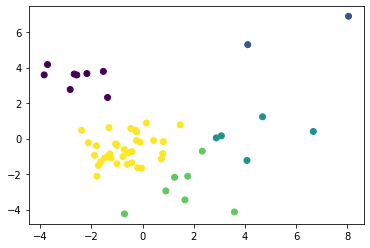

In [75]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(df_norm.values)
plt.scatter(pca_features[:,0],pca_features[:,1],c=df_norm.Clusters)

## Modeling

In [150]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score,mean_absolute_error
from sklearn.model_selection import GridSearchCV

### Train-Test-Split

In [151]:
pred_var = 'Native_Present'
X = df_norm.drop(pred_var,axis=1).values
y = df_norm[pred_var].values

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=42)

## Linear Regression Model

In [152]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(X_train,y_train)
y_pred = linreg.predict(X_test)
print('Explained Variance: ',explained_variance_score(y_test,y_pred))
print('Mean square error: ',mean_squared_error(y_test,y_pred))
print('Mean absolute error: ',mean_absolute_error(y_test,y_pred))
print('R2 score/Coeff. of determination: ',linreg.score(X_test,y_test))

Explained Variance:  0.9709911714370564
Mean square error:  0.02302506599590203
Mean absolute error:  0.13206964806701527
R2 score/Coeff. of determination:  0.9704778460266613


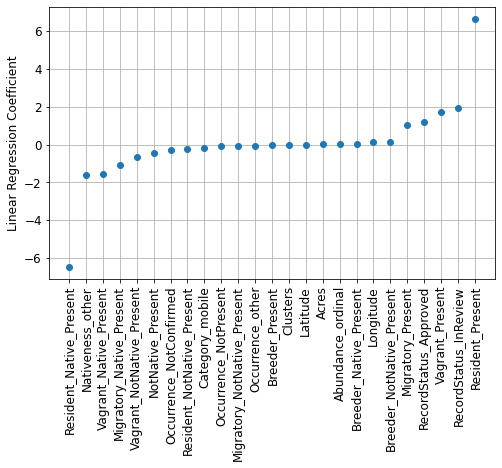

In [166]:
linreg = LinearRegression()
linreg.fit(X_train,y_train)
def argsort(seq):
    # http://stackoverflow.com/questions/3071415/efficient-method-to-calculate-the-rank-vector-of-a-list-in-python
    return sorted(range(len(seq)), key=seq.__getitem__)
ind = argsort(linreg.coef_)
plt.figure(figsize=(8,5))
plt.plot(range(len(ind)),linreg.coef_[ind],'.',ms=12)
plt.xticks(range(len(ind)),labels=df_norm.drop(pred_var,axis=1).columns[ind],rotation=90,fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Linear Regression Coefficient',fontsize=12)
plt.grid()
plt.show()

## Decision Tree Regressor

In [167]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=7,max_features=9, random_state=42)
tree_reg.fit(X_train, y_train)
y_pred = tree_reg.predict(X_test)

print('Mean square error: ',mean_squared_error(y_test,y_pred))
print('R2 score/Coeff. of determination: ',r2_score(y_test,y_pred))

Mean square error:  0.29328559363638146
R2 score/Coeff. of determination:  0.6239566716101347


In [205]:
print('Most important Features:')
ind = argsort(tree_reg.feature_importances_)
for i in ind[-5:None]:
    print('{} : {:.1f}%'.format(df_norm.drop(pred_var,axis=1).columns[i],100*tree_reg.feature_importances_[i]))

Most important Features:
Migratory_Native_Present : 3.7%
Vagrant_Native_Present : 6.5%
Breeder_Present : 12.0%
RecordStatus_Approved : 30.8%
Abundance_ordinal : 35.5%


In [209]:
cat_01 = 'RecordStatus_Approved'
cat_02 = 'Abundance_ordinal'
title = 'Record Status vs. Abundance'
title_cat_01 = '# Record Status Approved'
title_cat_02 = 'Abundance (ordinal)'
fig =bubbleplot(df_park,cat_01,cat_02,title,title_cat_01,title_cat_02,x_axis_type='linear',cross_plot=parks_endangered)


## Gradient Boosting Regressor

In [171]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(random_state=42,min_samples_leaf=1,max_depth=3,max_features=6,subsample=0.5,n_estimators=150)
# Fit the model on the trainng data.
gbr.fit(X_train, y_train)
# Print the accuracy from the testing data.
y_pred = gbr.predict(X_test)
print('Explained Variance: ',explained_variance_score(y_test,y_pred))
print('Mean square error: ',mean_squared_error(y_test,y_pred))
print('Mean absolute error: ',mean_absolute_error(y_test,y_pred))
print('R2 score/Coeff. of determination: ',r2_score(y_test,y_pred))

Explained Variance:  0.6754990592320642
Mean square error:  0.2692243031806314
Mean absolute error:  0.3966810804501647
R2 score/Coeff. of determination:  0.6548074462293391


In [208]:
print('Most important Features:')
gbr = GradientBoostingRegressor(random_state=42,min_samples_leaf=1,max_depth=3,max_features=6,subsample=0.5,n_estimators=150)
gbr.fit(X_train, y_train)
ind = argsort(gbr.feature_importances_)
for i in ind[-5:]:
    print('{} : {:.1f}%'.format(df_norm.drop(pred_var,axis=1).columns[i],100*gbr.feature_importances_[i]))

Most important Features:
Vagrant_Native_Present : 5.8%
Vagrant_Present : 6.5%
Breeder_Native_Present : 8.1%
Breeder_Present : 19.6%
RecordStatus_Approved : 20.3%


In [217]:
cat_01 = 'RecordStatus_Approved'
cat_02 = 'Breeder_Present'
title = 'Record Status vs. Breeder Species'
title_cat_01 = '# Record Status Approved'
title_cat_02 = '# Breeder Species'
fig =bubbleplot(df_park,cat_01,cat_02,title,title_cat_01,title_cat_02,x_axis_type='linear',cross_plot=parks_endangered)


# Conclusions

## Size does not matter (that much..)

It might seem logical that the size of the national park should play an important role for the abundance of native species, but the given data set does not show such a relationship.

In [220]:
cat_01 = 'Acres'
cat_02 = 'Native_Present'
title = 'Area vs. Native Species'
title_cat_01 = 'Park Area (acres)'
title_cat_02 = '# Native Species'
fig =bubbleplot(df_park,cat_01,cat_02,title,title_cat_01,title_cat_02,x_axis_type='log',cross_plot=parks_endangered)

## Monitoring is key

The more record stati were approved, the more native species are detected. This could just highlight the difference in maintenance and not in actual species abundance. **Still, if we want to protect our native species, it is key to know where they are**.

In [219]:
cat_01 = 'RecordStatus_Approved'
cat_02 = 'Native_Present'
title = 'Record Status vs. Native Species'
title_cat_01 = '# Record Status Approved'
title_cat_02 = '# Native Species'
fig =bubbleplot(df_park,cat_01,cat_02,title,title_cat_01,title_cat_02,x_axis_type='linear',cross_plot=parks_endangered)
